Importing Libraries

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from datetime import datetime
from pandas import DatetimeIndex, to_datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import pickle
import sys
from sys import exc_info

Loading Data

In [26]:
user_data = pd.read_csv("C:/Users/Godwin/Documents/Workflow/Clustering/movielen/ml-100k/u.data", names = ['user id', 'item id', 'rating', 'timestamp'], sep = '\s+')

movie_data = pd.read_csv("C:/Users/Godwin/Documents/Workflow/Clustering/movielen/ml-100k/u.item",  names = ["movie id", "movie title", "release date", "video release date",
              "IMDb URL", "unknown", "Action", "Adventure", "Animation", 
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", 
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", 
              "Thriller", "War", "Western"], sep = "|")

user_info = pd.read_csv("C:/Users/Godwin/Documents/Workflow/Clustering/movielen/ml-100k/u.user", names = ["user id", "age", "gender", "occupation", "zip code"], sep = '|')

In [27]:
#Viewing User Data
user_data.head()

,user id,item id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [28]:
#Viewing Movie Data
movie_data.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [29]:
#Viewing User Info
user_info.head()

,user id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


Data Engineering

In [30]:
#User data engineering

user_data['timestamp'] = [datetime.utcfromtimestamp(i).strftime('%d/%m/%Y') for i in (user_data['timestamp'])]
user_data['timestamp'] = pd.to_datetime(user_data['timestamp'])

user_data['year'] = pd.DatetimeIndex(user_data['timestamp']).year
user_data['month'] = pd.DatetimeIndex(user_data['timestamp']).month
user_data['day'] = pd.DatetimeIndex(user_data['timestamp']).day
user_data.drop(['timestamp'], axis = 1, inplace = True)
user_data.head()

,user id,item id,rating,year,month,day
0,196,242,3,1997,4,12
1,186,302,3,1998,4,4
2,22,377,1,1997,7,11
3,244,51,2,1997,11,27
4,166,346,1,1998,2,2


In [31]:
#Checking for null values
user_data.isnull().sum()

user id    0
item id    0
rating     0
year       0
month      0
day        0
dtype: int64

In [32]:
#Movie Data Engineering
movie_data.drop(['video release date', 'release date', 'IMDb URL'], axis = 1, inplace = True)

movie_data['movie title'] = [i.split('(')[0] for i in movie_data['movie title']]

movie_data.rename(columns = {'movie id': 'item id'}, inplace = True)
movie_data.head()

,item id,movie title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [33]:
#Checking for null values
movie_data.isnull().sum()

item id        0
movie title    0
unknown        0
Action         0
Adventure      0
Animation      0
Children's     0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

Merging Data

In [34]:
df = user_data.merge(user_info, on = 'user id')
data = movie_data.merge(df, on = 'item id')

Data Engineering

In [35]:
# Selecting datapoints where movies were rated by atleast 100 people
data = data.groupby(['item id'])
data = data.filter(lambda x: x['user id'].count() > 100)

# Selecting datapoints where rating is above 4
data = data[data['rating'] >= 4]

# Selecting the first 200 unique movies
item_list = np.unique(data['item id'])[:200]
data = data.loc[data['item id'].isin(item_list)]

#Selecting the first 500 unique users
first_500 = np.unique(data['user id'])[:500]
data = data.loc[data['user id'].isin(first_500)]

#Distinct Users
users = np.unique(data['user id'])

In [36]:
# Selecting Movies a user likes
def moviesListForUsers(users, users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies
    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['userId'] == user]['movieId'])).split('[')[1].split(']')[0])
    return users_movies_list

Data Encoding

In [37]:
le = LabelEncoder()

data['occupation'] = le.fit_transform(data['occupation'])
occupation_mapping = dict(zip(le.classes_, range(len(le.classes_))))

data['gender'] = le.fit_transform(data['gender'])
gender_mapping = dict(zip(le.classes_, range(len(le.classes_))))

#data['movie title'] = le.fit_transform(data['movie title'])
#title_mapping = dict(zip(le.classes_, range(len(le.classes_))))
data_copy = data.copy()

data.drop(['movie title', 'zip code', 'month', 'day','year', 'occupation', 'gender','rating'], axis = 1, inplace = True)

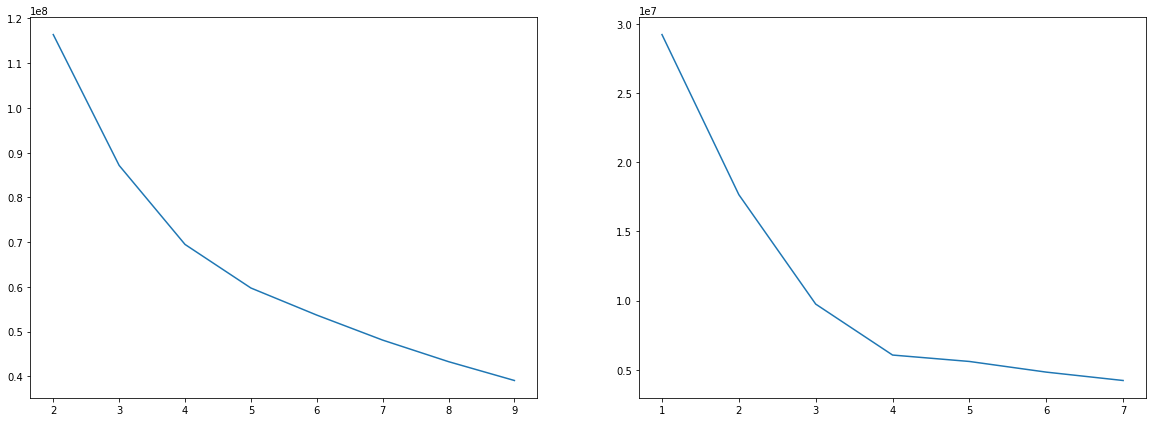

In [38]:
#Elbow method for choosing number of Clusters

k = range(2,10)
distortion = []
distortions = []

for i in k:
    model = KMeans(n_clusters = i +2, max_iter = 200, random_state= 0)
    model.fit(data)
    #distortion.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    distortion.append(model.inertia_)

for i in range(len(distortion) -1):
    distortions.append(distortion[i] - distortion[i+1])

len_differences = len(distortions)
X_differences = range(1, len_differences + 1)

fig, ax = plt.subplots(1,2, figsize = (20,7))
ax[0].plot(k, distortion)
ax[1].plot(X_differences,distortions)

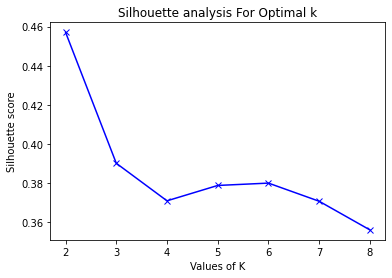

In [39]:
#Silhouette method for choosing number of clusters

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters:
      # initialise kmeans
      kmeans = KMeans(n_clusters=num_clusters)
      kmeans.fit(data)
      cluster_labels = kmeans.labels_
 
      # silhouette score
      silhouette_avg.append(silhouette_score(data, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

Fitting The Model

In [40]:
kmeans = KMeans(n_clusters= 4, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(data)

In [41]:
#Assigning Users to Clusters
df = {'user id': data['user id'], 'Clusters': clusters}
users_cluster = pd.DataFrame(df)
#users_cluster.T

In [42]:
users_cluster['Clusters'].value_counts()

1    4569
3    3735
2    3685
0    3523
Name: Clusters, dtype: int64

In [43]:
#Returns Movies in a cluster

def clustersMovies(users_cluster, users_data):
    #User_cluster - Dataframe that consist of user id and their respective cluster
    #Users_data - Dataframe that consist of user data

    clusters = list(users_cluster['Clusters'])
    each_cluster_movies = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(users_cluster[users_cluster['Clusters'] == i]['user id'])
        users_movies_list = list()
        for user in users_list:    
            users_movies_list.extend(list(users_data[users_data['user id'] == user]['item id']))
        users_movies_counts = list()
        users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['item id', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_movies

cluster_movies = clustersMovies(users_cluster, data)

In [44]:
cluster_movies[1].head()

,item id,Count
0,50,3475
1,174,3223
2,98,2913
3,100,2908
4,56,2832


Saving Clustering Files

In [45]:
class saveLoadFiles:
    def save(self, filename, data):
        try:
            file = open(filename + '.pkl', 'wb')
            pickle.dump(data, file)
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            file.close()
            return [True]
    def load(self, filename):
        try:
            file = open(filename + '.pkl', 'rb')
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            data = pickle.load(file)
            file.close()
            return data
    def loadClusterMoviesDataset(self):
        return self.load('clusters_movies_dataset')
    def saveClusterMoviesDataset(self, data):
        return self.save('clusters_movies_dataset', data)
    def loadUsersClusters(self):
        return self.load('users_clusters')
    def saveUsersClusters(self, data):
        return self.save('users_clusters', data)

In [46]:
saveLoadFile = saveLoadFiles()
saveLoadFile.saveClusterMoviesDataset(cluster_movies)
saveLoadFile.saveUsersClusters(users_cluster)

[True]

In [47]:
#Returns the movies a particular user liked
def getMoviesOfUser(user_id, users_data):
    return list(users_data[users_data['user id'] == user_id]['item id'])

Recommending Movies

In [48]:
class userRequestedFor:
    def __init__(self, user_id, users_data):
        self.users_data = users_data.copy()
        self.user_id = user_id
        # Find User Cluster
        users_cluster = saveLoadFiles().loadUsersClusters()
        self.user_cluster = np.unique(users_cluster[users_cluster['user id'] == self.user_id]['Clusters'])
    
        # Load User Cluster Movies Dataframe
        self.movies_list = saveLoadFiles().loadClusterMoviesDataset()

        self.cluster_movies_list = []
        for i in self.user_cluster:
            self.cluster_movies = self.movies_list[i] # dataframe
            self.cluster_movies_list.extend(list(self.cluster_movies['item id'])) # list
    def updatedFavouriteMoviesList(self, new_movie_Id):
        if new_movie_Id in self.cluster_movies_list:
            self.cluster_movies.loc[self.cluster_movies['item id'] == new_movie_Id, 'Count'] += 1
        else:
            self.cluster_movies = self.cluster_movies.append([{'item id':new_movie_Id, 'Count': 1}], ignore_index=True)
        self.cluster_movies.sort_values(by = ['Count'], ascending = False, inplace= True)
        self.movies_list[self.user_cluster] = self.cluster_movies
        saveLoadFiles().saveClusterMoviesDataset(self.movies_list)

    def recommendMostFavouriteMovies(self):
        try:
            user_movies = getMoviesOfUser(self.user_id, self.users_data)
            cluster_movies_list = self.cluster_movies_list.copy()
            for user_movie in user_movies:
                if user_movie in cluster_movies_list:
                    cluster_movies_list.remove(user_movie)
            return [True, cluster_movies_list]
        except KeyError:
            err = "User history does not exist"
            print(err)
            return [False, err]
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            return [False, err]

In [49]:
user12Recommendations = userRequestedFor(9, data).recommendMostFavouriteMovies()[1]
for movie in user12Recommendations[:10]:
    title = np.unique(list(data_copy.loc[data_copy['item id'] == movie]['movie title']))
    print('Movie title: ', title)

Movie title:  ['Raiders of the Lost Ark ']
Movie title:  ['Silence of the Lambs, The ']
Movie title:  ['Fargo ']
Movie title:  ['Pulp Fiction ']
Movie title:  ['Return of the Jedi ']
Movie title:  ['Shawshank Redemption, The ']
Movie title:  ['Empire Strikes Back, The ']
Movie title:  ['Fugitive, The ']
Movie title:  ['Toy Story ']
Movie title:  ['Godfather, The ']
